<a href="https://colab.research.google.com/github/AntoninaKOR/training-code-ml/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22delete_background_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transparent_background

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 42.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=54f937d3621adad754321d41e51a9e947a5a85bf986e07a3aa33c9b7407ddd28
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 5.4 MB/s eta 0:00:00


In [ ]:
!pip install -q transformers

In [ ]:
from PIL import Image
import torchvision.transforms as T
from transparent_background import Remover
import torchvision
import torch
import torchmetrics as TM
from enum import IntEnum
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from transformers import AutoProcessor, AutoModelForUniversalSegmentation
import cv2

**Тестовое задание по удаление фона:**\
Требуется разработать алгоритм с использованием нейронных сетей по удалению фона у центрального объекта изображения.\
В данной задаче вам надо самим найти или создать датасет, самостоятельно определить подход к удалению фона и реализовать его.

Решение этой задачи можно распределить на два этапа:
1. распознование объекта, построение маски, которая будет разделять объекты и фон.
2.наложение полученной маски на изображение, что равносильно удалению фона.
Применять нейросети мы будет на первом этапе.

# Первый путь

**Выбор датасета**.\
Датасеты для сегментации можно разделить на те, где результат сегментации - маска (т.е. обьекты выделены попискельно) или боксами (выделены границы, где находится объект). Для распознавания машин на дороге лучше, например, боксы, так как это быстрее. Но нам нужно выделить сам обьект попиксельно для удаления фона.\
Так же, на мой взгляд, в задаче удаления фона есть два варианта: распознавание фона и распознования объектов, находящихся на фоне. Первый вариант подходит, если фон однотипен, но в задаче нет никаких ограничений на фоне, так что этот вариант нам не подходит.
Во втором варианте есть ограничение на количество типов объектов, которые нейросеть может распознать, и на количество объектов определенного типа.\
Если мы не знаем, какой обект надо отделить от фона,желательно выбрать датасет с максимально разнообразными метками.\
Если знаем, то выбираем датасет с наибольним количеством объекта с нужной нам меткой.

**Instance segmentation vs Semantic segmentation**\
При выборе типа сегментизации стоит остановиться на instance segmentation, так как, например, если мы ищем машину на дороге, логичнее помечать каждую машину отдельной меткой, и тогда за центральный объект можно будет взять машину, занимающую наибольшее количество пикселей, а не все пиксели с меткой "машина", как было бы при semantic segmentation.

## Выбранные датасеты

Возьмем несколько популярных датасетов, подходящих под задачу Instance segmentation, с сайта
paperswithcode.com:
1.  LVIS:\
https://paperswithcode.com/dataset/lvis
2.COCO:\
https://paperswithcode.com/dataset/coco
3. ADE20K\
https://paperswithcode.com/dataset/ade20k


Это большие датасеты, на них обучены многие хорошие модели, и по ним часто их оценивают и сравнивают.



## Выбранные модели

Вызьмем несколько популярных предобученных моделей, их можно выбрать, например, из числа моделей указанных на страницах, выбранных датасетов, на paperswithcode.com.
1. SAM (https://github.com/facebookresearch/segment-anything)
2. OneFormer\
 (https://github.com/SHI-Labs/OneFormer)
3. YOLOv5 Instance Segmentation (https://github.com/ultralytics/yolov5)
4. Mask RCNN (https://github.com/matterport/Mask_RCNN)
5. HQ-SAM (https://github.com/supervisely-ecosystem/serve-segment-anything-hq)


Краткий обзор на плюсы и минусы моделей можно посмотреть в этой статье:
https://medium.com/@rustemgal/zero-training-object-detection-81820c30073f


Возьмем OneFormer.

Кроме знакомых многим instance segmentation и semantic segmentation, я ходе поиска моделей и данных я столкнулась с Salient Object Detection. Задача Salient Object Detection как раз заключается в выделением главных объектов, что нам и нужно для вырезания фона.

# Второй путь

## Выбранные датасеты

Выберем датасеты с сайтов https://github.com/GrassBro/SODdataset?tab=readme-ov-file и https://paperswithcode.com/task/salient-object-detection:
1. UHRSD (https://paperswithcode.com/dataset/uhrsd)
2. DUTS-TE (https://paperswithcode.com/sota/salient-object-detection-on-duts-te)
3. ECSSD (https://paperswithcode.com/sota/salient-object-detection-on-ecssd)
4. HKU-IS (https://paperswithcode.com/sota/salient-object-detection-on-hku-is)
5. PASCAL-S (https://paperswithcode.com/sota/salient-object-detection-on-pascal-s)

## Выбранные модели


1. InSPyReNet (https://paperswithcode.com/paper/revisiting-image-pyramid-structure-for-high#code)
2. M3Net (https://github.com/I2-Multimedia-Lab/M3Net)
3. TRACER (https://github.com/Karel911/TRACER)
4. PGNet (https://github.com/iCVTEAM/PGNet)

Выберем модель InSPyReNet, так как она показывает лучший скор S-Measure, на многих вышеуказанных датасетах.

# Сравнение

Ради интереса возьмем датасет OXFORDIIITPET, и сравним на нем, на сколько хорошо обнаруживают котиков, модели предобученные SAM, InSPyReNet, и написанная и обученная мной модель на этом небольшом датасете.

## Подготовка датасета

In [ ]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")
def to_device(x):
    if torch.cuda.is_available():
        return x.cuda()
    else:
        return x.cpu()

In [ ]:
# перевод тензора в PIL изображения
t2img = T.ToPILImage()
# перевод PIL в тензор
img2t = T.ToTensor()
#удаление всех графов
def close_figures():
    while len(plt.get_fignums()) > 0:
        plt.close()

In [ ]:
pet_train = torchvision.datasets.OxfordIIITPet('/content/data/train',download=True, split='trainval', target_types="segmentation")
pet_test = torchvision.datasets.OxfordIIITPet('/content/data/test',download=True, split='test', target_types="segmentation")

100%|██████████| 791918971/791918971 [00:39<00:00, 20075200.89it/s]


Extracting /content/data/train/oxford-iiit-pet/images.tar.gz to /content/data/train/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 10783792.60it/s]


Extracting /content/data/train/oxford-iiit-pet/annotations.tar.gz to /content/data/train/oxford-iiit-pet


100%|██████████| 791918971/791918971 [00:29<00:00, 27224911.85it/s]


Extracting /content/data/test/oxford-iiit-pet/images.tar.gz to /content/data/test/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 13370536.09it/s]


Extracting /content/data/test/oxford-iiit-pet/annotations.tar.gz to /content/data/test/oxford-iiit-pet


In [ ]:
class TrimapClasses(IntEnum):
    PET = 0
    BACKGROUND = 1
    BORDER = 2

def trimap2f(trimap):
    return (img2t(trimap) * 255.0 - 1)/2

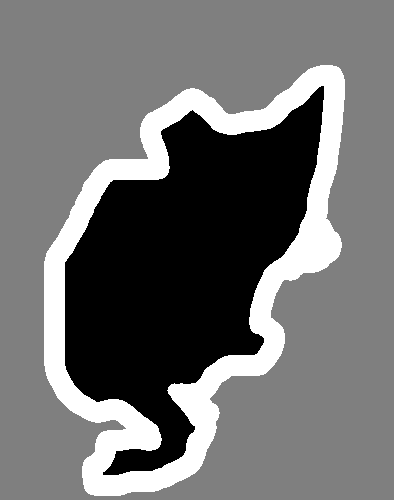

In [ ]:
t2img(trimap2f(pet_train[0][1]))

In [ ]:
class ToDevice(torch.nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device = device

    def forward(self, img):
        return img.to(self.device)

In [ ]:
#Аугментация
class Augmented_ds(torchvision.datasets.OxfordIIITPet):
    def __init__(
        self,
        root: str,
        split: str,
        target_types="segmentation",
        download=False,
        pre_transform=None,
        post_transform=None,
        pre_target_transform=None,
        post_target_transform=None,
        common_transform=None,
    ):
        super().__init__(
            root=root,
            split=split,
            target_types=target_types,
            download=download,
            transform=pre_transform,
            target_transform=pre_target_transform,
        )
        self.post_transform = post_transform
        self.post_target_transform = post_target_transform
        self.common_transform = common_transform

    def __len__(self):
        return super().__len__()

    def __getitem__(self, idx):
        (input, target) = super().__getitem__(idx)

        # обединим два изображения, чтобы преобразовать их вместе, потом снова разделяем
        if self.common_transform is not None:
            both = torch.cat([input, target], dim=0)
            both = self.common_transform(both)
            (input, target) = torch.split(both, 3, dim=0)
        if self.post_transform is not None:
            input = self.post_transform(input)
        if self.post_target_transform is not None:
            target = self.post_target_transform(target)

        return (input, target)

In [ ]:
def tensor_trimap(t):
    x = t * 255
    x = x.to(torch.long)
    x = x - 1
    return x

def args_to_dict(**kwargs):
    return kwargs

transform_dict = args_to_dict(
    pre_transform=T.ToTensor(),
    pre_target_transform=T.ToTensor(),
    common_transform=T.Compose([
        ToDevice(get_device()),
        T.Resize((64, 64), interpolation=T.InterpolationMode.NEAREST),
        T.RandomHorizontalFlip(p=0.5),
    ]),
    post_transform=T.Compose([
        T.ColorJitter(contrast=0.3),
    ]),
    post_target_transform=T.Compose([
        T.Lambda(tensor_trimap),
    ]),
)

pet_train = Augmented_ds(
    root='/content/data/train',
    split="trainval",
    target_types="segmentation",
    download=False,
    **transform_dict,
)
pet_test = Augmented_ds(
    root='/content/data/test',
    split="test",
    target_types="segmentation",
    download=False,
    **transform_dict,
)

pet_train_loader = torch.utils.data.DataLoader(
    pet_train,
    batch_size=64,
    shuffle=True,
)
pet_test_loader = torch.utils.data.DataLoader(
    pet_test,
    batch_size=21,
    shuffle=True,
)

pet_train[0][0].shape

torch.Size([3, 64, 64])

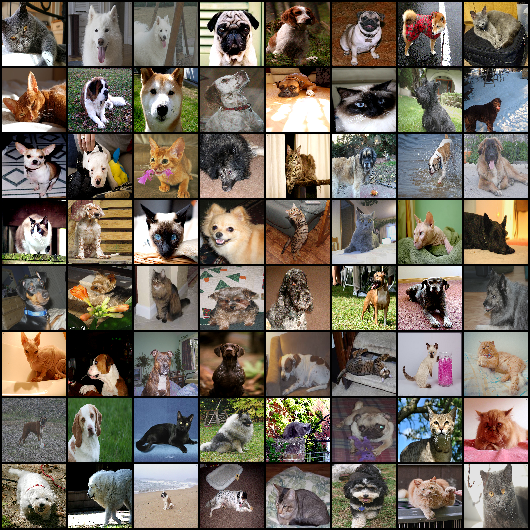

In [ ]:
(train_pets_inputs, train_pets_targets) = next(iter(pet_train_loader))
(test_pets_inputs, test_pets_targets) = next(iter(pet_test_loader))
pets_input_grid = torchvision.utils.make_grid(train_pets_inputs, nrow=8)
t2img(pets_input_grid)

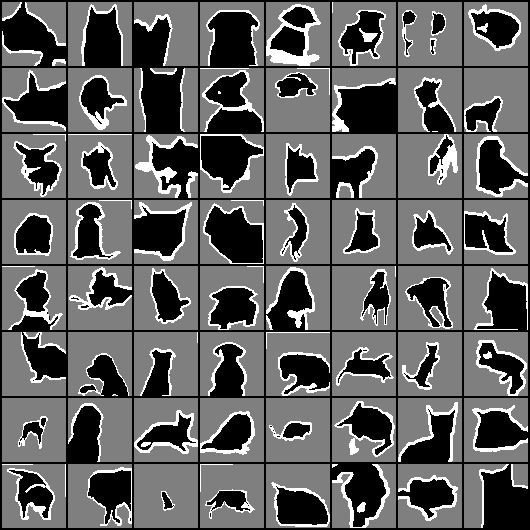

In [ ]:
# тензор маски имеет значени 0, 1, 2, а для получения изображений нужно подать в функцию тензор со значениями от 0 до 1
t2img(torchvision.utils.make_grid(train_pets_targets / 2.0, nrow=8))

## Обучение модели

In [ ]:


class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.out_channels = 3
        self.c1 = nn.Conv2d(3, 1, kernel_size =(3, 3), stride=(1, 1))
        self.relu= nn.ReLU()
        self.c2=nn.Conv2d(1, 64, kernel_size = (3, 3), stride=(1, 1))
        self.c2dt1 = nn.ConvTranspose2d(64, 64,  kernel_size =(3, 3), stride=(1, 1))
        self.c2dt2= nn.ConvTranspose2d(65, 3,  kernel_size =(3, 3), stride=(1, 1))
    def forward(self, x):
      x1 = self.c1(x)
      x1 = self.relu(x1)
      x2 = self.c2(x1)
      x2 = self.relu(x2)
      x2 = self.c2dt1(x2)
      x2 = self.relu(x2)
      merged = torch.cat([x2, x1], axis=1)
      merged = self.c2dt2(merged)
      merged = self.relu(merged)
      return merged

In [ ]:
#проверка правильности модели
m = Model()
m.eval()
to_device(m)
m(to_device(train_pets_inputs)).shape

torch.Size([64, 3, 64, 64])

In [ ]:
def IoUMetric(pred, gt, softmax=False):
    if softmax is True:
        pred = nn.Softmax(dim=1)(pred)

    # добавляем encoded masks для 3 каналов
    gt = torch.cat([ (gt == i) for i in range(3) ], dim=1)
    intersection = gt * pred
    union = gt + pred - intersection

    # суммируем по всем размерностям кроме 0 (размер батча)
    iou = (intersection.sum(dim=(1, 2, 3)) + 0.001) / (union.sum(dim=(1, 2, 3)) + 0.001)

    # Compute the mean over the batch dimension.
    return iou.mean()

class IoULoss(nn.Module):
    def __init__(self, softmax=False):
        super().__init__()
        self.softmax = softmax

    # pred => Predictions (logits, B, 3, H, W)
    # gt => Ground Truth Labales (B, 1, H, W)
    def forward(self, pred, gt):
        # Воспользуемся iouloss из UnitBox: An Advanced Object Detection Network,чтобы функция была дифференцируемой, а не обычное (1 - IoU)
        return -(IoUMetric(pred, gt, self.softmax).log())


In [ ]:
#проверка
x = torch.rand((2, 3, 2, 2), requires_grad=True)
y = torch.randint(0, 3, (2, 1, 2, 2), dtype=torch.long)
z = IoULoss(softmax=True)(x, y)
z

tensor(1.7149, grad_fn=<NegBackward0>)

In [ ]:
#Обучение
def train_model(model, loader, optimizer):
    to_device(model.train())
    cel = True
    if cel:
        criterion = nn.CrossEntropyLoss(reduction='mean')
    else:
        criterion = IoULoss(softmax=True)
    #текущие значения
    running_loss = 0.0
    running_samples = 0

    for batch_idx, (inputs, targets) in enumerate(loader, 0):
        optimizer.zero_grad()
        inputs = to_device(inputs)
        targets = to_device(targets)
        outputs = model(inputs)

        # Нам нужно удалить размерность каналов перед передачей в CrossEntropyLoss,
        #чтобы он имел форму NHW, где каждый элемент - класс пикселя
        if cel:
            targets = targets.squeeze(dim=1) #squeeze удаляет размерность
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_samples += targets.size(0)
        running_loss += loss.item()

    print("Trained {} samples, Loss: {:.4f}".format(
        running_samples,
        running_loss / (batch_idx+1),
    ))

In [ ]:
def print_test_dataset_masks(model, test_pets_targets, test_pets_labels, epoch, save_path, show_plot):
    to_device(model.eval())
    predictions = model(to_device(test_pets_targets))
    test_pets_labels = to_device(test_pets_labels)
    pred = nn.Softmax(dim=1)(predictions)

    pred_labels = pred.argmax(dim=1)
    # возвращает пространство каналов
    pred_labels = pred_labels.unsqueeze(1)
    pred_mask = pred_labels.to(torch.float)

    iou = to_device(TM.classification.MulticlassJaccardIndex(3, average='micro', ignore_index=TrimapClasses.BACKGROUND))
    iou_accuracy = iou(pred_mask, test_pets_labels)
    pixel_metric = to_device(TM.classification.MulticlassAccuracy(3, average='micro'))
    pixel_accuracy = pixel_metric(pred_labels, test_pets_labels)
    custom_iou = IoUMetric(pred, test_pets_labels)
    title = f'Epoch: {epoch:02d}, Accuracy[Pixel: {pixel_accuracy:.4f}, IoU: {iou_accuracy:.4f}, Custom IoU: {custom_iou:.4f}]'
    print(title)

    close_figures()

    fig = plt.figure(figsize=(10, 12))
    fig.suptitle(title, fontsize=12)

    fig.add_subplot(3, 1, 1)
    plt.imshow(t2img(torchvision.utils.make_grid(test_pets_targets, nrow=7)))
    plt.axis('off')
    plt.title("Targets")

    fig.add_subplot(3, 1, 2)
    plt.imshow(t2img(torchvision.utils.make_grid(test_pets_labels.float() / 2.0, nrow=7)))
    plt.axis('off')
    plt.title("Ground Truth Labels")

    fig.add_subplot(3, 1, 3)
    plt.imshow(t2img(torchvision.utils.make_grid(pred_mask / 2.0, nrow=7)))
    plt.axis('off')
    plt.title("Predicted Labels")

    if save_path is not None:
        plt.savefig(os.path.join(save_path, f"epoch_{epoch:02}.png"), format="png", bbox_inches="tight", pad_inches=0.4)
    # end if

    if show_plot is False:
        close_figures()
    else:
        plt.show()

In [ ]:
def test_dataset_accuracy(model, loader):
    to_device(model.eval())
    iou = to_device(TM.classification.MulticlassJaccardIndex(3, average='micro', ignore_index=TrimapClasses.BACKGROUND))
    pixel_metric = to_device(TM.classification.MulticlassAccuracy(3, average='micro'))

    iou_accuracies = []
    pixel_accuracies = []
    custom_iou_accuracies = []

    for batch_idx, (inputs, targets) in enumerate(loader, 0):
        inputs = to_device(inputs)
        targets = to_device(targets)
        predictions = model(inputs)

        pred_probabilities = nn.Softmax(dim=1)(predictions)
        pred_labels = predictions.argmax(dim=1)

        # добавляем размерность
        pred_labels = pred_labels.unsqueeze(1)
        pred_mask = pred_labels.to(torch.float)

        iou_accuracy = iou(pred_mask, targets)
        pixel_accuracy = pixel_metric(pred_labels, targets)
        custom_iou = IoUMetric(pred_probabilities, targets)
        iou_accuracies.append(iou_accuracy.item())
        pixel_accuracies.append(pixel_accuracy.item())
        custom_iou_accuracies.append(custom_iou.item())

        del inputs
        del targets
        del predictions

    iou_tensor = torch.FloatTensor(iou_accuracies)
    pixel_tensor = torch.FloatTensor(pixel_accuracies)
    custom_iou_tensor = torch.FloatTensor(custom_iou_accuracies)

    print("Test Dataset Accuracy")
    print(f"Pixel Accuracy: {pixel_tensor.mean():.4f}, IoU Accuracy: {iou_tensor.mean():.4f}, Custom IoU Accuracy: {custom_iou_tensor.mean():.4f}")


Epoch: 00, Accuracy[Pixel: 0.2830, IoU: 0.5110, Custom IoU: 0.1997]


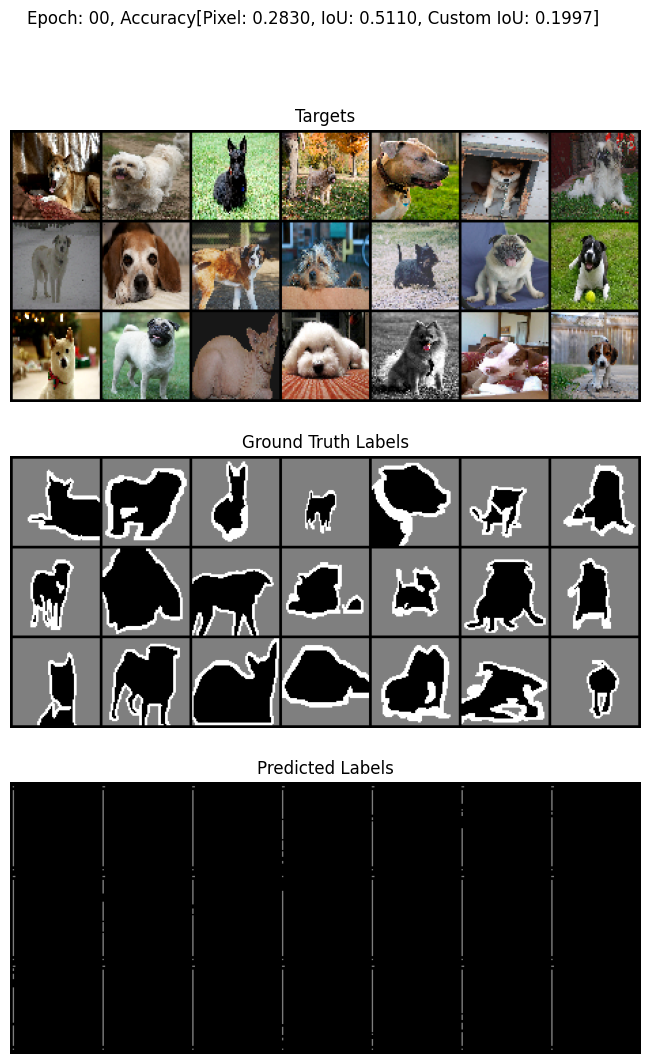

In [ ]:
# приверка, правильно ли работают функции
print_test_dataset_masks(m, test_pets_inputs, test_pets_targets, epoch=0, save_path=None, show_plot=True)

In [ ]:
to_device(m)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.7)

In [ ]:
def train_loop(model, loader, test_data, epochs, optimizer, scheduler, save_path):
    test_inputs, test_targets = test_data
    for i in range(epochs):
        epoch = i
        print(f"Epoch: {(i+1):02d}, Learning Rate: {optimizer.param_groups[0]['lr']}")
        train_model(model, loader, optimizer)
        with torch.inference_mode():
            print_test_dataset_masks(model, test_inputs, test_targets, epoch=epoch, save_path=save_path, show_plot=(epoch == (epochs-1)))

        if scheduler is not None:
            scheduler.step()
        print("")

Epoch: 01, Learning Rate: 0.001
Trained 3680 samples, Loss: 1.0028
Epoch: 00, Accuracy[Pixel: 0.5953, IoU: 0.0039, Custom IoU: 0.2744]

Epoch: 02, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.9317
Epoch: 01, Accuracy[Pixel: 0.5983, IoU: 0.0000, Custom IoU: 0.3198]

Epoch: 03, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.8888
Epoch: 02, Accuracy[Pixel: 0.6002, IoU: 0.0232, Custom IoU: 0.3359]

Epoch: 04, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.8803
Epoch: 03, Accuracy[Pixel: 0.6016, IoU: 0.0307, Custom IoU: 0.3439]

Epoch: 05, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.8674
Epoch: 04, Accuracy[Pixel: 0.6029, IoU: 0.0799, Custom IoU: 0.3446]

Epoch: 06, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.8576
Epoch: 05, Accuracy[Pixel: 0.6122, IoU: 0.1445, Custom IoU: 0.3558]

Epoch: 07, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.8500
Epoch: 06, Accuracy[Pixel: 0.6108, IoU: 0.1129, Custom IoU: 0.3721]

Epoch: 08, Learning Rate: 0.0007
Trained 3680 sa

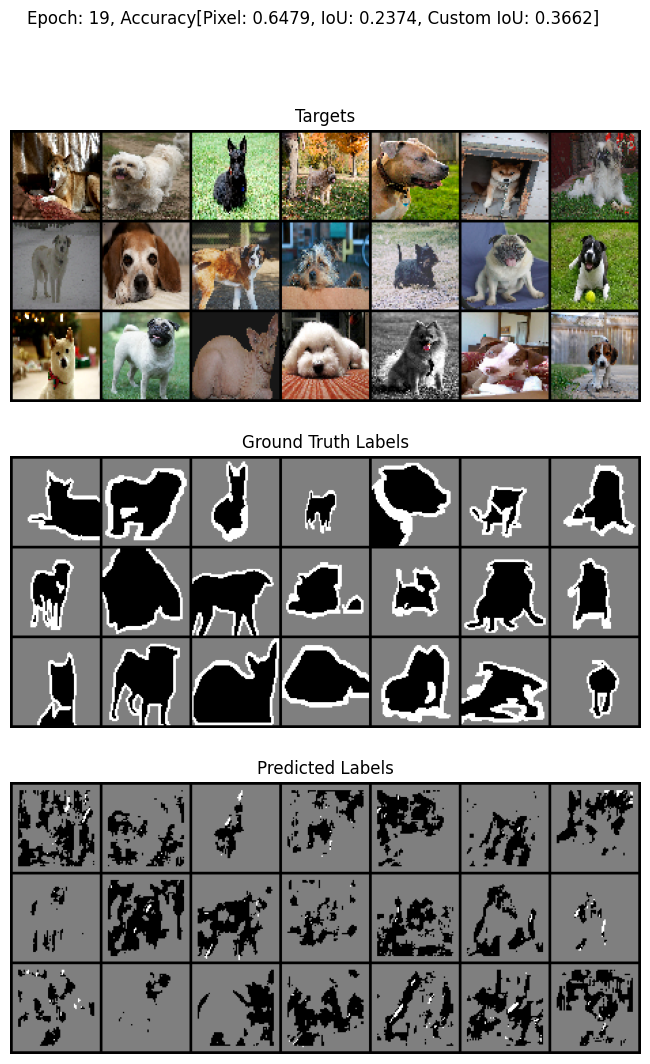

In [ ]:
train_loop(m, pet_train_loader, (test_pets_inputs, test_pets_targets), 20, optimizer, scheduler, None)

## OneFormer


Посмотрим только одно изображения, так как бесплатного озу гугл коллаба на большее не хватает.

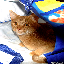

In [ ]:
t2img(pet_train[0][0])

In [ ]:
processor = AutoProcessor.from_pretrained("shi-labs/oneformer_coco_swin_large")
OneFormer = AutoModelForUniversalSegmentation.from_pretrained("shi-labs/oneformer_coco_swin_large")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/6.82k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/oneformer/image_processing_oneformer.py:426: FutureWarning: The `reduce_labels` argument is deprecated and will be removed in v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(


coco_panoptic.json:   0%|          | 0.00/5.85k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/82.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/879M [00:00<?, ?B/s]

In [ ]:
#подготовка изображений для модели
instance_inputs = processor(images=pet_train[0][0], task_inputs=["instance"],do_rescale=False,do_resize=True,  return_tensors="pt")

In [ ]:
with torch.no_grad():
  outputs = OneFormer(**instance_inputs)

In [ ]:
instance_segmentation = processor.post_process_instance_segmentation(outputs)[0]

In [ ]:
instance_segmentation

{'segmentation': tensor([[2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 0,  ..., 2, 2, 2],
         ...,
         [0, 0, 0,  ..., 2, 2, 2],
         [0, 0, 0,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2]], dtype=torch.int32),
 'segments_info': [{'id': 1,
   'label_id': 15,
   'was_fused': False,
   'score': 0.998269},
  {'id': 2, 'label_id': 59, 'was_fused': False, 'score': 0.840993}]}

In [ ]:
#кошки и собаки имеют label_id равный 15 и 16. Оставим только их
l = list()
for dic in instance_segmentation['segments_info']:
  if (dic['label_id'] == 15 or  dic['label_id'] == 16):
    l.append(dic['id'])
instance_segmentation['segmentation'] = torch.where(sum(instance_segmentation['segmentation']==i for i in l).bool(), instance_segmentation['segmentation'], 0)

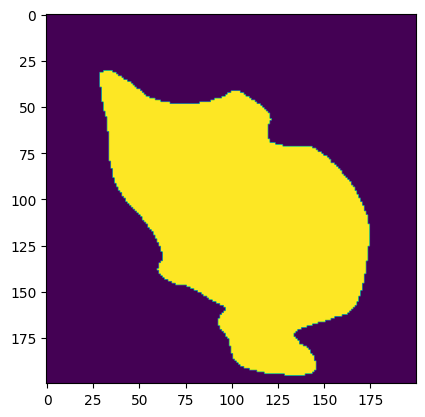

In [ ]:
def draw_instance_segmentation(segmentation, segments_info):
    fig, ax = plt.subplots()
    ax.imshow(segmentation)

draw_instance_segmentation(**instance_segmentation)

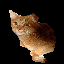

In [ ]:
t2img(pet_train[0][0]*img2t(t2img(instance_segmentation['segmentation']).resize((64, 64))))

## InSPyReNet

In [ ]:
remover = Remover(mode = 'fast') #учтем, что разработчики написали, что только при fast mode хорошо работает на меленьких изображениях
out = remover.process(t2img(pet_train[0][0]), type='map')

Settings -> Mode=fast, Device=cpu, Torchscript=disabled


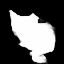

In [ ]:
out

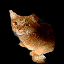

In [ ]:
t2img(img2t(out)*pet_train[0][0])